In [1]:
%pylab inline
import tensorflow as tf
import sys
sys.path.insert(0, '../python')

Populating the interactive namespace from numpy and matplotlib


/local/home/fnammour/miniconda3/envs/TFgpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/local/home/fnammour/miniconda3/envs/TFgpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/local/home/fnammour/miniconda3/envs/TFgpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/local/home/fnammour/m

# Step I: Reading data

In [2]:
from DeepDeconv.utils.batch_utils import dynamic_batches

In [3]:
#Input the directory containing the fits file
data_directory = '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/'
write_path="/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/"

#Retrieves the list of all the files
import glob

gal_files = glob.glob(data_directory+'image-*-multihdu.fits')
gal_files.sort()

SNR = [20,100]#Range of SNR simulated
noiseless_img_hdu = 0
psf_hdu = 1
targets_hdu = 2
deconv_mode = 'TIKHONOV'

In [4]:
gen = dynamic_batches(gal_files[2:] , batch_size=32, noise_std=None, SNR=SNR, 
                noiseless_img_hdu=noiseless_img_hdu, targets_hdu=targets_hdu,
                psf_hdu=psf_hdu, image_dim=96, image_per_row=100,
                deconv_mode=deconv_mode)

In [5]:
a = next(gen)

In [6]:
a[0].shape, a[1].shape, a[2].shape

((32, 96, 96, 1), (32, 96, 96, 1), (32,))

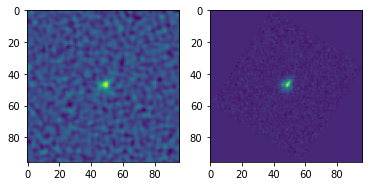

In [7]:
subplot(121)
imshow(a[0][3,:,:,0])
subplot(122)
imshow(a[1][3,:,:,0])

## Step II: Define a network

In [8]:
# Disclaimer.... this is a very stupod network
inputs = tf.keras.Input(shape=[96, 96, 1])

net = tf.keras.layers.Conv2D(32, 3, padding='same')(inputs)
net = tf.keras.layers.Activation('relu')(net)
net = tf.keras.layers.Conv2D(16, 3, padding='same')(net)

outputs = tf.keras.layers.Conv2D(1, 3, padding='same')(net)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [9]:
# Compile the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer = tf.keras.optimizers.Adam(lr=1e-3), loss = 'mse', metrics=['accuracy'])

## Step III: Training

In [10]:
# Train the model
history = model.fit_generator(gen, 
                              steps_per_epoch=100,
                              epochs=20)

Epoch 1/20
100/100 [==============================] - 29s 289ms/step - loss: 0.2000 - acc: 0.0000e+00
Epoch 2/20
100/100 [==============================] - 14s 144ms/step - loss: 0.1526 - acc: 0.0000e+00
Epoch 3/20
100/100 [==============================] - 14s 145ms/step - loss: 0.1481 - acc: 0.0000e+00
Epoch 4/20
100/100 [==============================] - 63s 626ms/step - loss: 0.1568 - acc: 0.0000e+00
Epoch 5/20
100/100 [==============================] - 14s 139ms/step - loss: 0.1520 - acc: 0.0000e+00
Epoch 6/20
100/100 [==============================] - 14s 138ms/step - loss: 0.1465 - acc: 0.0000e+00
Epoch 7/20
100/100 [==============================] - 13s 132ms/step - loss: 0.1484 - acc: 0.0000e+00
Epoch 8/20
100/100 [==============================] - 13s 128ms/step - loss: 0.1408 - acc: 0.0000e+00
Epoch 9/20
100/100 [==============================] - 13s 129ms/step - loss: 0.1458 - acc: 0.0000e+00
Epoch 10/20
100/100 [==============================] - 52s 521ms/step - loss: 0.14

dict_keys(['loss', 'acc'])


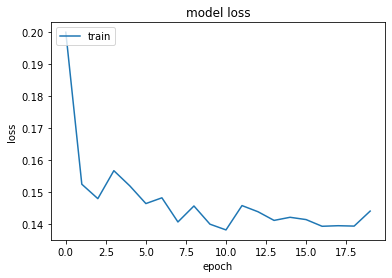

In [11]:
# have a look at history
history
# list all data in history
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

## Step IV: Applying the model

In [12]:
# The model can be applied like so:
res = model(a[0].astype('float32'))
# This should return the solution of the deconvolution prblm
res_np = tf.keras.backend.eval(res).squeeze(axis=-1) #convert solution to numpy array and remove last dimension

Text(0.5, 1.0, 'Deconvolved')

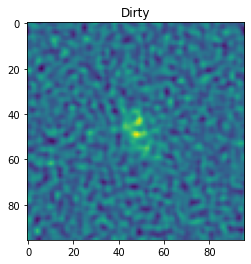

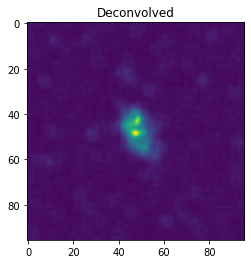

In [13]:
# Show a deconvolved image
figure()
imshow(a[0][0].squeeze(axis=-1))
title('Dirty')
figure()
imshow(res_np[0])
title('Deconvolved')